In [1]:
# The following piece of code gives the opportunity to show multiple outputs
# in one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

### Binary Classification
- The data `ziptrain.csv` and `ziptest.csv` are used and explored.
- From `ziptrain` dataset I have selected only the rows corresponding to digits $2$ and $7$ and saved them in a new dataset called `binar_train`. Same thing is done in `ziptest` and it is called `binar_test`. 
- I have projected `binar_train` onto the first two principal components and made a scatterplot of the data in the new space.
- Data is Fitted by a logistic regression, in the new space,to separate digits $2$ and $7$. I have evaluated the trainded model on `binar_test` using 
    + recall,
    + precision,
    + accuracy, and 
    + appropriate F-measure.
- A confusion matrix is built for the predictions.
- Now, instead of using only $2$ principle components, I have projected `binar_train` onto the first $m=2, 3, ...$ principal components (one $m$ at a time), and trained a logistic classifier each time.  
### Multi-Classification <span style="color:green">(BONUS: 25 points)</span>
- I have projected the `ziptrain` (**not `binar_train`**) onto first two principal components and made a scatterplot to confirm wheather or not only two principal components separates **all** digits properly.
- I have used a linear discriminant on `ziptrain` over the $256$ original pixels and built the confusion matrix for the trained model over `ziptrain` (**not `ziptest`**).
- Then, I have used a linear disciminant in spaces of $m=2,3,...$ PCs to train the classifier and the result is evaluated by the **precision** of predictions over `ziptest` dataset.

In [2]:
#Question 1
import pandas as pd
import numpy as np
#Upload and Explore the data
filename = 'data/ziptrain.csv'
zip_train = np.loadtxt(filename)
#zip_train.shape()

filename = 'data/ziptest.csv'
zip_test = np.loadtxt(filename)
#zip_test.shape()

# Only keep 2 and 7
#Test Data
binar_test_2 = zip_test[zip_test[:, 0] == 2]
print(zip_test[:, 0] == 2)
print(binar_test_2.shape)

binar_test_7 = zip_test[zip_test[:, 0] == 7]
print(zip_test[:, 0] == 7)
print(binar_test_7.shape)

binar_test_2_7 = np.vstack([binar_test_2, binar_test_7])
binar_test_2_7.shape

#Train Data
binar_train_2 = zip_train[zip_train[:, 0] == 2]
print(zip_train[:, 0] == 2)
print(binar_train_2.shape)

binar_train_7 = zip_train[zip_train[:, 0] == 7]
print(zip_train[:, 0] == 7)
print(binar_train_7.shape)

binar_train_2_7 = np.vstack([binar_train_2, binar_train_7])
binar_train_2_7.shape

#Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# remove the first column (image label)
import matplotlib.pyplot as plt
pca.fit(binar_train_2_7[:, 1:])
Z = pca.transform(binar_train_2_7[:,1:])
pd.DataFrame(Z).head()
plt.scatter(Z[:,0], Z[:,1], c= binar_train_2_7[:,0], alpha=0.3);

#The data is well separated for most of the parts.

#Logistic Regeression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
predictors = Z
outcome = (binar_train_2_7[:,0] > 4)*1
lr.fit(predictors, outcome)
print(lr.intercept_, lr.coef_)
plt.figure()
plt.scatter(Z[binar_train_2_7[:,0]==2,0], Z[binar_train_2_7[:,0]==2,1], marker='$2$', 
            color='blue', alpha = 0.3);

plt.scatter(Z[binar_train_2_7[:,0]==7,0], Z[binar_train_2_7[:,0]==7,1], marker='$7$', 
            color='red', alpha = 0.3);

# Prediction
y_pred_2_7=lr.predict(pca.transform(binar_test_2_7[:,1:]))
y_pred_2_7_int=lr.predict(pca.transform(binar_test_2_7[:,1:]))
for i in range(0,len(y_pred_2_7_int)):
   if int(y_pred_2_7_int[i])==0:
    y_pred_2_7_int[i]=2
   else:
     y_pred_2_7_int[i]=7

#Precision, Accuracy and Recall

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(binar_test_2_7[:,0], y_pred_2_7_int))

for i in range(0,len(binar_test_2_7[:,0])):
   if binar_test_2_7[i,0]==2:
    binar_test_2_7[i,0]=False
   else:
     binar_test_2_7[i,0]=True

print("Precision:",metrics.precision_score(binar_test_2_7[:,0], y_pred_2_7))
print("Recall:",metrics.recall_score(binar_test_2_7[:,0], y_pred_2_7))

#### Confusion Matrix

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(binar_test_2_7[:,0], y_pred_2_7)
cnf_matrix

#m principal components
from sklearn import model_selection
# 10-fold CV, with shuffle
n = len(binar_train_2_7)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True)

lr = LogisticRegression()
r2 = []

# Calculate R2 with only the intercept 
#(no principal components in regression)
y=binar_train_2_7[:,0]
score = model_selection.cross_val_score(lr, np.ones((n,1)), \
                                        y.ravel(), cv=kf_10, \
                                           scoring='r2').mean()    
r2.append(score)

# Calculate R2 using CV for the 11 principle components, 
#adding one component at the time.
for i in np.arange(1, 12):
    score = model_selection.cross_val_score(lr, binar_train_2_7[:,:i], \
                                            y.ravel(), cv=kf_10, \
                                               scoring='r2').mean()
    r2.append(score)
    
# Plot results
plt.figure()
plt.plot(r2, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('R Squared')

# we select M=2 and will perform the test on test data
M=2
pca2 = PCA()
from sklearn.preprocessing import scale

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

r2 = []

# Calculate R2 with only the intercept (no principal components in regression)
score = model_selection.cross_val_score(lr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='r2').mean()   
r2.append(score)

# Calculate R2 using CV for the 5 principal components, adding one component at the time.
for i in np.arange(1, 6):
 score = model_selection.cross_val_score(lr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='r2').mean() 
 r2.append(score)

plt.figure()    
plt.plot(np.array(r2), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('R Squared')



# Train regression model on training data 

lr.fit(binar_train_2_7[:,:M], binar_train_2_7[:,0])



[False False False ... False False False]
(198, 257)
[False False False ... False False False]
(147, 257)


(345, 257)

[False False False ... False False False]
(731, 257)
[False False False ... False False False]
(645, 257)


(1376, 257)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

,0,1
0,6.170833,1.125082
1,-3.317885,-1.851948
2,3.073119,-4.297047
3,4.008856,0.497935
4,6.956282,-5.635829


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[-1.18390371] [[-1.52707338 -0.32453092]]


<Figure size 640x480 with 0 Axes>

Accuracy: 0.9652173913043478
Precision: 0.9655172413793104
Recall: 0.9523809523809523


array([[193,   5],
       [  7, 140]], dtype=int64)

<Figure size 640x480 with 0 Axes>

Text(0.5,0,'Number of principal components in regression')

Text(0,0.5,'R Squared')

<Figure size 640x480 with 0 Axes>

Text(0.5,0,'Number of principal components in regression')

Text(0,0.5,'R Squared')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Question 2 <span style="color:red">(50 points)</span>

The objective of this exercise is to understand the notions of underfitting and overfitting. Using cross-validation on simulated data, we will be able to visualize the two concepts.

##### Synthetic data
1. Generate 100 points equally distanced from -20 to 20 and save them in a `numpy` array `x`.
2. Create a new numpy array `y` defined as $y_i=\mathrm{sin}(x_i) + 0.05 x_i^3 + \varepsilon_i$ where $\varepsilon_i \sim \mathcal{N}(0,100^2)$, for $i=1,...,100$.
3. Plot the scatter plot of `x` and `y`. Do you think that a linear model could fit this data?

##### Underfitting vs. Overfitting
4. Fit a linear regression model and call it `model1` : $y=\beta_0 + \beta_1 x$ and add the fitted line over the scatter plot.
5. Compute the mean squared error of `model1`. **Hint** : You can use `sklearn.metrics.mean_squared_error`.
6. Fit a polynomial regression model with degree 5 and call it `model2` : $y=\beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_5 x^5$. **Hint** : You can use `sklearn.preprocessing.PolynomialFeatures` in order to create a **new** input array that includes $x^0$, $x^1$, $x^2$, $x^3$ ...
7. Add the fitted curve over the scatter plot and compare `model2` and `model1`.
8. Compute the mean squared error of `model2`.
9. Fit a polynomial regression model with degree 20 and call it `model3` : $y=\beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_{20} x^{20}$.
10. Add the fitted curve over the scatter plot and compare the three models. What is the mean squared error of `model3`?

##### Cross-Validation
11. Using $10$-fold cross-validation, compute the **averaged validation** mean squared errors for all possible polynomial models by varying the degree of the polynomial model from $1$ to $20$.
12. Plot the **averaged validation** MSE with respect to the degree of the model. **Hint** : $x$-axis is defined as the degree of the polynomial model, i.e., $1,2,3,...,20$ and $y$-axis is its associated MSE.


##### LASSO
13. Using $10$-fold cross-validation and the LASSO regularization, fit the polynomial model with degree 20 and call it `model4`. What is the best regularization constant? Show it in a curve. **Hint** : Here, you need to apply the $10$-fold cross-validation over a sequence of regularization constants. The figure will show you what is the best regularization constant, based on MSE or $R^2$.
14. Based on the LASSO model, what is the best final model? **Hint** : Once you have chosen the best regularization constant, you can extract the associated coefficients.

<Figure size 432x288 with 0 Axes>

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

[19.84185113] [[12.51768688]]


<Figure size 432x288 with 0 Axes>

Text(0.5,0,'x')

Text(0,0.5,'y')

14953.723474741812


array([-5.88328435e-05, -4.55633570e-04,  8.15488006e-02,  9.82018286e-02,
       -2.06372385e+00,  1.03770443e+01])

8848.120637298109


array([ 7.70937874e-20,  8.54304008e-19, -1.55868427e-16, -1.67274329e-15,
        1.33690236e-13,  1.39025977e-12, -6.32047127e-11, -6.36068276e-10,
        1.78913810e-08,  1.73402733e-07, -3.07608007e-06, -2.83982162e-05,
        3.09351838e-04,  2.66114108e-03, -1.62325324e-02, -1.24412844e-01,
        3.14689810e-01,  1.97015266e+00,  1.57654368e+00,  8.08017104e+00,
       -2.54142154e+01])

11848.303757858357


<Figure size 432x288 with 0 Axes>

array([13.03467423, 21.21397158])

array([-0.04881511, 13.03467423, 27.85414134])

array([ 0.05182459, -0.04881511,  0.34719333, 27.85414134])

array([ 1.88105774e-04,  5.18245925e-02, -1.14589481e-01,  3.47193328e-01,
        3.05370141e+01])

array([-6.27390555e-05,  1.88105774e-04,  8.02548607e-02, -1.14589481e-01,
       -2.13709260e+00,  3.05370141e+01])

array([ 1.50177421e-06, -6.27390555e-05, -6.46812206e-04,  8.02548607e-02,
       -1.13936293e-03, -2.13709260e+00,  2.83350516e+01])

array([-8.99843287e-07,  1.50177421e-06,  5.29653361e-04, -6.46812206e-04,
       -2.94674894e-02, -1.13936293e-03,  2.83000393e+00,  2.83350516e+01])

array([ 1.21805812e-08, -8.99843287e-07, -7.76009065e-06,  5.29653361e-04,
        1.52950108e-03, -2.94674894e-02, -1.62280089e-01,  2.83000393e+00,
        3.01576504e+01])

array([ 1.42173926e-09,  1.21805812e-08, -2.12560222e-06, -7.76009065e-06,
        8.78935006e-04,  1.52950108e-03, -6.59198030e-02, -1.62280089e-01,
        3.84146478e+00,  3.01576504e+01])

array([-1.35796064e-10,  1.42173926e-09,  1.43043419e-07, -2.12560222e-06,
       -5.16037169e-05,  8.78935006e-04,  7.47430057e-03, -6.59198030e-02,
       -4.41263455e-01,  3.84146478e+00,  3.22204177e+01])

array([ 6.84207731e-11, -1.35796064e-10, -7.14419412e-08,  1.43043419e-07,
        2.59384317e-05, -5.16037169e-05, -3.81849058e-03,  7.47430057e-03,
        2.52287555e-01, -4.41263455e-01, -2.12697492e+00,  3.22204177e+01])

array([ 3.18755204e-12,  6.84207731e-11, -3.85228918e-09, -7.14419412e-08,
        1.76073736e-06,  2.59384317e-05, -3.74393283e-04, -3.81849058e-03,
        3.63932327e-02,  2.52287555e-01, -1.38075622e+00, -2.12697492e+00,
        3.71110066e+01])

array([-5.47238330e-13,  3.18755204e-12,  7.61594238e-10, -3.85228918e-09,
       -4.07873612e-07,  1.76073736e-06,  1.03966081e-04, -3.74393283e-04,
       -1.25680041e-02,  3.63932327e-02,  6.69959230e-01, -1.38075622e+00,
       -7.77536340e+00,  3.71110066e+01])

array([-5.09513476e-14, -5.47238330e-13,  7.28446851e-11,  7.61594238e-10,
       -4.11438352e-08, -4.07873612e-07,  1.16231611e-05,  1.03966081e-04,
       -1.70733653e-03, -1.25680041e-02,  1.21716685e-01,  6.69959230e-01,
       -3.41521507e+00, -7.77536340e+00,  4.49639014e+01])

array([ 1.19760295e-14, -5.09513476e-14, -1.81195312e-11,  7.28446851e-11,
        1.10462869e-08, -4.11438352e-08, -3.46344929e-06,  1.16231611e-05,
        5.88302095e-04, -1.70733653e-03, -5.18013235e-02,  1.21716685e-01,
        2.06365590e+00, -3.41521507e+00, -2.20019566e+01,  4.49639014e+01])

array([ 1.27937165e-15,  1.19760295e-14, -2.05589862e-12, -1.81195312e-11,
        1.34617155e-09,  1.10462869e-08, -4.61057278e-07, -3.46344929e-06,
        8.80896638e-05,  5.88302095e-04, -9.24035281e-03, -5.18013235e-02,
        4.84515823e-01,  2.06365590e+00, -1.00355844e+01, -2.20019566e+01,
        6.46518299e+01])

array([ 9.55560616e-17,  1.27937165e-15, -1.47282478e-13, -2.05589862e-12,
        9.09379635e-11,  1.34617155e-09, -2.84833287e-08, -4.61057278e-07,
        4.67403840e-06,  8.80896638e-05, -3.58914714e-04, -9.24035281e-03,
        6.44849504e-03,  4.84515823e-01,  4.62545432e-01, -1.00355844e+01,
       -9.23513491e+00,  6.46518299e+01])

array([-2.03183755e-19,  9.55560616e-17,  1.63815708e-15, -1.47282478e-13,
       -2.31936743e-12,  9.09379635e-11,  1.45027860e-09, -2.84833287e-08,
       -4.84973614e-07,  4.67403840e-06,  9.13080547e-05, -3.58914714e-04,
       -9.48285102e-03,  6.44849504e-03,  4.93634151e-01,  4.62545432e-01,
       -1.01669972e+01, -9.23513491e+00,  6.49619013e+01])

array([-1.19393042e-18, -2.03183755e-19,  2.32178062e-15,  1.63815708e-15,
       -1.89205488e-12, -2.31936743e-12,  8.37311094e-10,  1.45027859e-09,
       -2.17816620e-07, -4.84973614e-07,  3.36311688e-05,  9.13080547e-05,
       -2.95317450e-03, -9.48285102e-03,  1.31936616e-01,  4.93634151e-01,
       -2.28617776e+00, -1.01669972e+01,  8.34717167e+00,  6.49619013e+01])

array([ 1.00247784e-19, -1.19393042e-18, -1.96992952e-16,  2.32178062e-15,
        1.65558518e-13, -1.89205488e-12, -7.77813713e-11,  8.37311094e-10,
        2.24026399e-08, -2.17816620e-07, -4.07764083e-06,  3.36311688e-05,
        4.65407922e-04, -2.95317450e-03, -3.17942876e-02,  1.31936616e-01,
        1.16718432e+00, -2.28617776e+00, -1.80242437e+01,  8.34717167e+00,
        8.00179132e+01])

Text(0.5,0,'Degree of Polynomial')

Text(0,0.5,'Error')

<Figure size 432x288 with 0 Axes>

Lasso(alpha=0.04, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.04555555555555556, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.05111111111111111, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.056666666666666664, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.06222222222222222, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.06777777777777777, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.07333333333333333, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.07888888888888888, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.08444444444444443, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.09, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

y
             0
0  -351.738695
1  -385.219604
2  -309.266115
3  -333.512236
4  -154.002719
5  -437.802316
6  -400.222054
7  -374.220362
8  -195.972581
9  -241.461548
10  -68.210927
11 -222.735566
12 -245.821619
13  -32.092973
14 -249.285400
15 -241.191000
16 -346.096290
17   41.019983
18  -73.443954
19  121.482853
20 -162.365412
21  103.854408
22  -86.751153
23 -139.421414
24   44.264104
25   15.849198
26   68.764402
27  -22.386458
28 -171.092400
29   77.770139
..         ...
70  288.080468
71   77.599184
72 -104.875033
73 -132.463458
74   -2.951859
75  178.406147
76  170.332899
77   55.731932
78  -92.516506
79   70.780930
80   92.870901
81  103.575926
82  107.771337
83  185.833777
84  293.028358
85  265.227509
86  304.706177
87  112.173925
88  136.699249
89  219.916929
90  304.739111
91  198.951524
92  346.309728
93  323.936776
94  399.083349
95  360.646580
96  314.473580
97  454.924779
98  232.426216
99  467.903989

[100 rows x 1 columns]


<Figure size 432x288 with 0 Axes>

Text(0.5,0,'Number of principal components in regression')

Text(0,0.5,'R Squared')

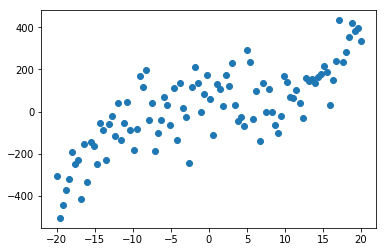

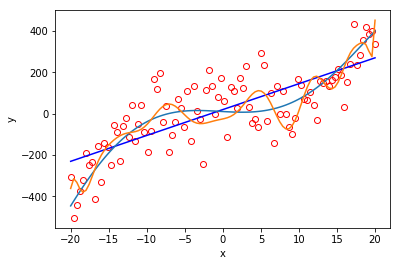

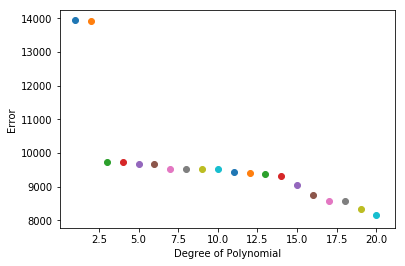

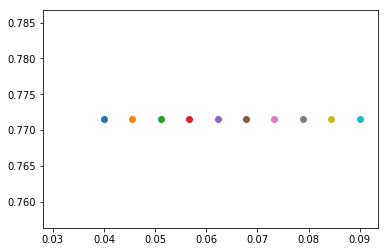

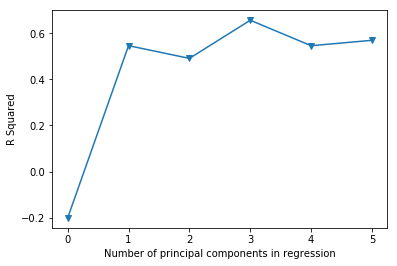

In [3]:
##Synthetic data
#Generate 100 points
import numpy as np
import math
p1=-20
p2=20
parts=100
x=np.linspace(p1, p2, parts)
#Create y
y=[]
eps=np.random.normal(0,100, 100)
for i in range(0,100):
    y_i=math.sin(x[i])+(0.05*x[i]**3)+eps[i]
    y.append(y_i)
#Plot Scatter of x,y
import matplotlib.pyplot as plt
plt.figure(1)
plt.scatter(x,y)
#We can fit a linear model over data, however, to be more accurate it is better to use a nonlinear model

##Underfitting vs. Overfitting
import pandas as pd
x = pd.DataFrame(data=x)
y = pd.DataFrame(data=y)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# fit the model and feed the data
lr.fit(X = x, y = y)
# regression parameters intercept is beta0 and coef_ is beta1
print(lr.intercept_, lr.coef_)
plt.figure(2)
plt.plot(x, y, 'or', mfc='none');
# add a regression line
plt.plot(x, lr.intercept_+lr.coef_*x, "-b");
plt.xlabel('x');
plt.ylabel('y');
#Mean Squard Error
model1=lr.intercept_+lr.coef_*x
import sklearn
print(sklearn.metrics.mean_squared_error(y,model1))
##Fit a degree five model
x=np.linspace(p1, p2, parts)
#Create y
y=[]
eps=np.random.normal(0,100, 100)
for i in range(0,100):
    y_i=math.sin(x[i])+(0.05*x[i]**3)+eps[i]
    y.append(y_i)
import numpy.polynomial.polynomial as poly
np.polyfit(x,y,5)
coefs = poly.polyfit(x, y, 5)
model2 = poly.polyval(x, coefs)
plt.plot(x, model2)
print(sklearn.metrics.mean_squared_error(y,model2))
##Fit a degree 20 model
x=np.linspace(p1, p2, parts)
#Create y
y=[]
eps=np.random.normal(0,100, 100)
for i in range(0,100):
    y_i=math.sin(x[i])+(0.05*x[i]**3)+eps[i]
    y.append(y_i)
import numpy.polynomial.polynomial as poly
np.polyfit(x,y,20)
coefs = poly.polyfit(x, y, 20)
model3 = poly.polyval(x, coefs)
plt.plot(x, model3)
print(sklearn.metrics.mean_squared_error(y,model2))
##compute the error for all possible degrees
x=np.linspace(p1, p2, parts)
#Create y
y=[]
eps=np.random.normal(0,100, 100)
for i in range(0,100):
    y_i=math.sin(x[i])+(0.05*x[i]**3)+eps[i]
    y.append(y_i)
import numpy.polynomial.polynomial as poly
plt.figure(3)
error=[]
for j in range(1,21):
    np.polyfit(x,y,j)
    coefs = poly.polyfit(x, y, j)
    model = poly.polyval(x, coefs)
    #plt.plot(x, model)
    error.append(sklearn.metrics.mean_squared_error(y,model))
    plt.scatter(j, sklearn.metrics.mean_squared_error(y,model))
plt.xlabel('Degree of Polynomial');
plt.ylabel('Error');
#Lasso and fitmodel
from sklearn import linear_model
kk=np.linspace(0.04, 0.09, 10)
plt.figure(4)
for k in kk:
 reg = linear_model.Lasso(alpha=k,normalize=True)
 x = pd.DataFrame(data=x)
 reg.fit(x,model3)
 model4=reg.predict(x)
 #plt.plot(x,model3)
 #plt.plot(x,model4)
 #print("R Squared:", reg.score(x, model3))
 from sklearn.metrics import mean_squared_error
# print("MSE:", mean_squared_error(model3, model4))
 plt.scatter(k,reg.score(x, model3))
#I select alpha=0.04 to have the highest R-square

## 10-fold CV, with shuffle
from sklearn import model_selection
import numpy as np
# 10-fold CV, with shuffle
y=np.reshape(y,(100,1))
y = pd.DataFrame(data=y)
print("y")
print(y)
n = len(x)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True)

regr = LinearRegression()
r2 = []

# Calculate R2 with only the intercept 
#(no principal components in regression)
score = model_selection.cross_val_score(regr, np.ones((n,1)), y.iloc[:,0], cv=kf_10, scoring='r2').mean()    
r2.append(score)

# Calculate R2 using CV for the 5 principle components, 
#adding one component at the time.
from sklearn.preprocessing import PolynomialFeatures

for i in np.arange(1, 6):
    score = model_selection.cross_val_score(regr, PolynomialFeatures(i).fit_transform(x), y, cv=kf_10, scoring='r2').mean()
    r2.append(score)
    
# Plot results
plt.figure(5)
plt.plot(r2, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('R Squared')